# Exploratory Analysis

In [1]:
import numpy as np
import pandas as pd

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

Notebook last run (end-to-end): 2025-02-05 00:06:07.378202


In [2]:
df = pd.read_csv("../data/high_diamond_ranked_10min.csv")

len(df.columns)

40

In [3]:
# gameId is entirely irrelevant
drop_columns = ["gameId"]

# blueEliteMonsters = blueDragons + blueHeralds, so we can drop it and redEliteMonsters
drop_columns += ["blueEliteMonsters", "redEliteMonsters"]

# There are a lot of features that are essentially just negatives (numeric or boolean) of other features, so we can drop those
drop_columns += ["redGoldDiff", "redExperienceDiff"]

# Search for games where neither team has a kill
print(f"Number of games where neither team has scored a kill by ten minutes: {len(df[(df['blueKills'] == 0) & (df['redKills'] == 0)])}")

Number of games where neither team has scored a kill by ten minutes: 0


In [4]:
# Search for games where blueGoldPerMin is blueTotalGold / 10, within a margin of error (and same for red)
print(f"Number of games where blueGoldPerMin is not blueTotalGold / 10: {len(df[abs(df['blueGoldPerMin'] - df['blueTotalGold'] / 10) > 0.001])}")
print(f"Number of games where redGoldPerMin is not redTotalGold / 10: {len(df[abs(df['redGoldPerMin'] - df['redTotalGold'] / 10) > 0.001])}")

Number of games where blueGoldPerMin is not blueTotalGold / 10: 0
Number of games where redGoldPerMin is not redTotalGold / 10: 0


In [5]:
# So blueGoldPerMin and redGoldPerMin are redundant
drop_columns += ["blueGoldPerMin", "redGoldPerMin"]

In [6]:
# Both teams have scored a kill by ten minutes in every game, so redFirstBlood is just 1 - blueFirstBlood, and we can drop it too
drop_columns += ["redFirstBlood"]

# See if there are any games where redDeaths is not equal to blueKills, or vice versa
print(f"Number of games where redDeaths is not equal to blueKills: {len(df[df['redDeaths'] != df['blueKills']])}")
print(f"Number of games where blueDeaths is not equal to redKills: {len(df[df['blueDeaths'] != df['redKills']])}")

Number of games where redDeaths is not equal to blueKills: 0
Number of games where blueDeaths is not equal to redKills: 0


In [7]:
# This is a bit surprising, because skilled players may voluntarily execute to deny kill gold to enemies in rare circumstances
# Since it hasn't happened once in this dataset, we can drop these columns
drop_columns += ["redDeaths", "blueDeaths"]
drop_columns

['gameId',
 'blueEliteMonsters',
 'redEliteMonsters',
 'redGoldDiff',
 'redExperienceDiff',
 'blueGoldPerMin',
 'redGoldPerMin',
 'redFirstBlood',
 'redDeaths',
 'blueDeaths']

In [8]:
df = df.drop(columns=drop_columns)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin
0,0,28,2,1,9,11,0,0,0,17210,...,8,0,0,0,16567,6.8,17047,197,55,19.7
1,0,12,1,0,5,5,0,0,0,14712,...,2,1,1,1,17620,6.8,17438,240,52,24.0
2,0,15,0,0,7,4,1,0,0,16113,...,14,0,0,0,17285,6.8,17254,203,28,20.3
3,0,43,1,0,4,5,0,1,0,15157,...,10,0,0,0,16478,7.0,17961,235,47,23.5
4,0,75,4,0,6,6,0,0,0,16400,...,7,1,0,0,17404,7.0,18313,225,67,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,5,1,0,0,17765,...,7,0,0,0,15246,6.8,16498,229,34,22.9
9875,1,54,0,0,6,8,1,0,0,16238,...,3,0,0,0,15456,7.0,18367,206,56,20.6
9876,0,23,1,0,6,5,0,0,0,15903,...,11,1,0,0,18319,7.4,19909,261,60,26.1
9877,0,14,4,1,2,3,1,0,0,14459,...,1,0,0,0,15298,7.2,18314,247,40,24.7


In [9]:
print(f"Number of features (columns): {len(df.columns)}")
print(f"Number of samples (rows): {len(df)}")
print(f"Number of games won by blue team: {len(df[df['blueWins'] == 1])} ({len(df[df['blueWins'] == 1])/len(df)*100:.2f}%)")
print(f"Number of NaN values: {df.isna().sum().sum()}")

Number of features (columns): 30
Number of samples (rows): 9879
Number of games won by blue team: 4930 (49.90%)
Number of NaN values: 0


### Aside: Is one side favored to win over the others in general?

We would expect both teams have an equal win rate, so the random variable blueWins would be a Binomial($n, 1/2$) random variable, and here $n=9879$.

In [10]:
# hypothesis test teams having equal win rate
sigma = np.sqrt(len(df) * 0.5 * 0.5)
mu = len(df) * 0.5
z = (len(df[df['blueWins'] == 1]) - mu) / sigma
print(f"z-score: {z}")

z-score: -0.19116003802485956


With a z-score of $-0.191$, we fail to reject the null hypothesis at the $p = 0.05$ significance level. In other words, the slightly higher win percentage favoring the blue team isn't suspicious.

In [11]:
# postfixes of columns for data that applies to both teams
team_column_names = [cname.removeprefix("blue") for cname in df.columns if cname.startswith("blue")]
#blue_data = df[[f"blue{cname}" for cname in team_column_names]].rename(columns={f"blue{cname}": cname for cname in team_column_names})
#blue_data["Wins"] = df["blueWins"]
#red_data = df[[f"red{cname}" for cname in team_column_names]].rename(columns={f"red{cname}": cname for cname in team_column_names})
#red_data["Wins"] = df["blueWins"].apply(lambda x: 1 - x)

### Examine Correlations

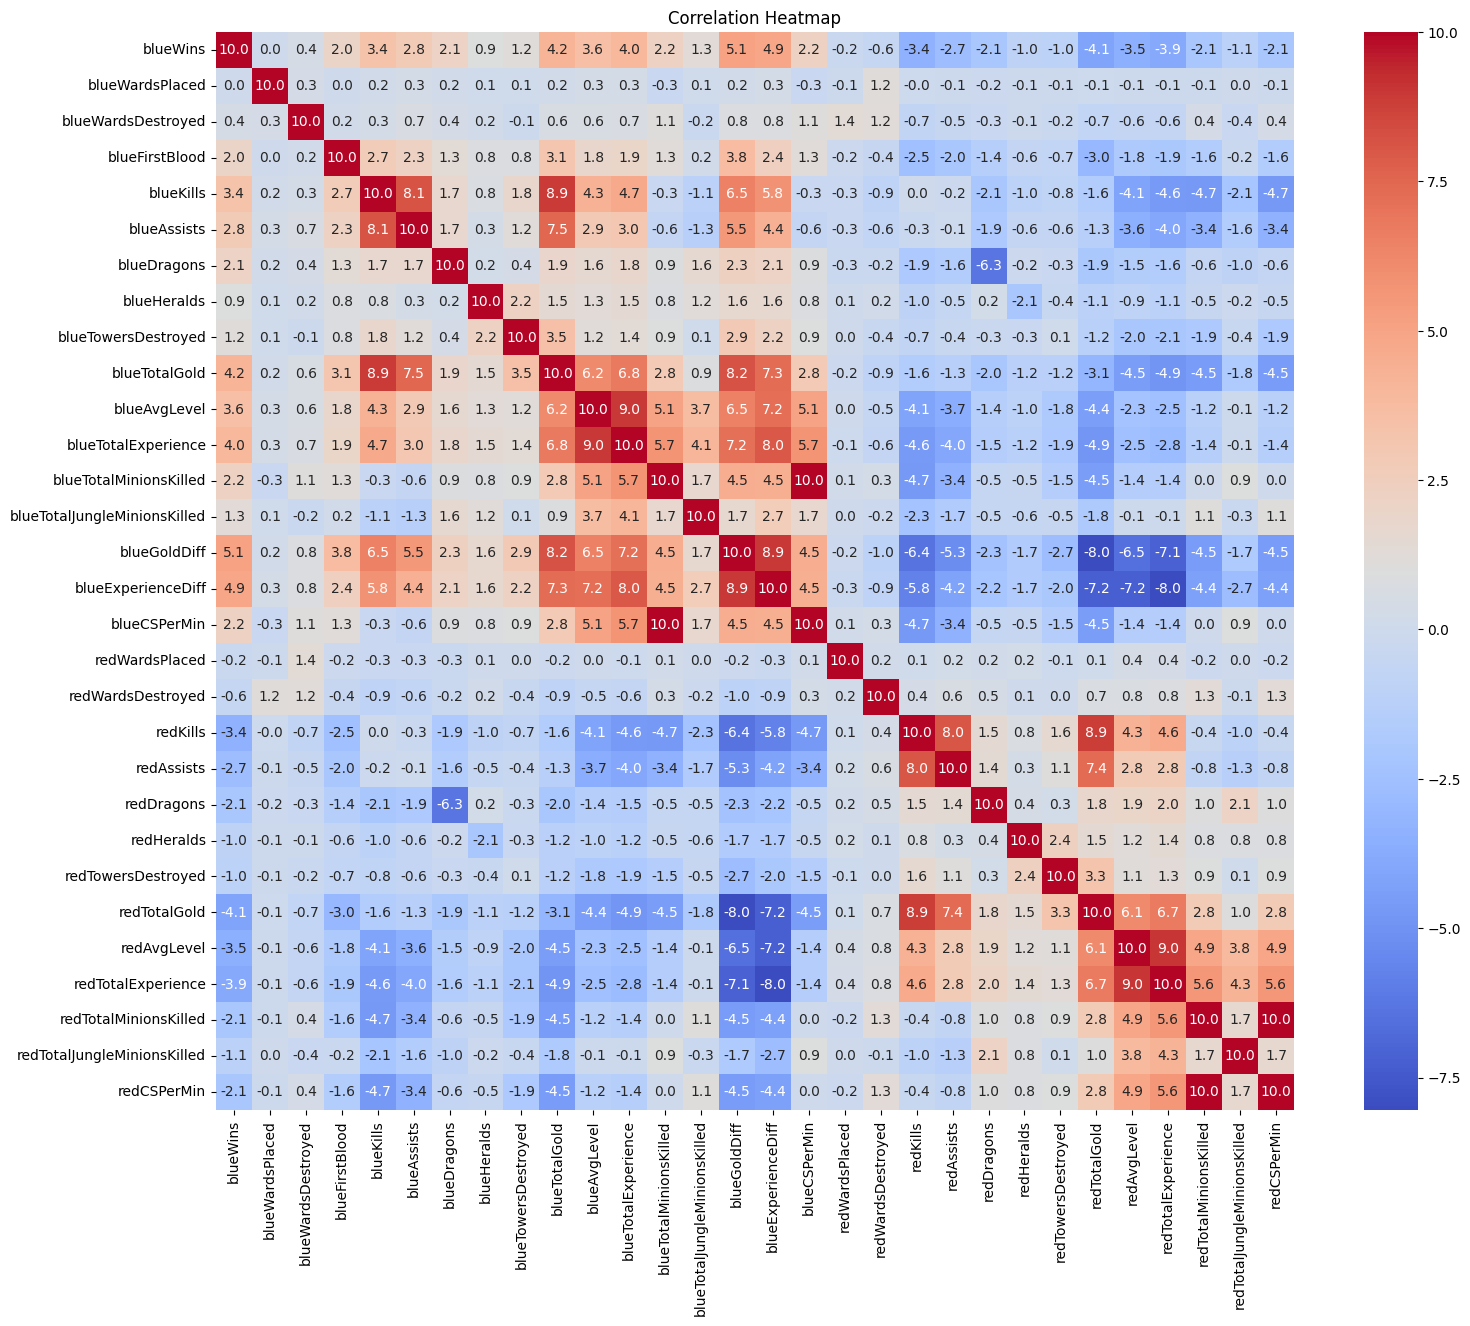

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df.corr()

# Plot the heatmap
plt.figure(figsize=(18, 14))
# multiply by 10 to make the numbers easier to read
sns.heatmap(10 * df_corr, annot=True, cmap='coolwarm', square=True, annot_kws={'size': 10}, fmt=".1f")
plt.title('Correlation Heatmap')
plt.show()

In [13]:
df_corr["blueWins"].sort_values(ascending=False).drop("blueWins")

blueGoldDiff                    0.511119
blueExperienceDiff              0.489558
blueTotalGold                   0.417213
blueTotalExperience             0.396141
blueAvgLevel                    0.357820
blueKills                       0.337358
blueAssists                     0.276685
blueCSPerMin                    0.224909
blueTotalMinionsKilled          0.224909
blueDragons                     0.213768
blueFirstBlood                  0.201769
blueTotalJungleMinionsKilled    0.131445
blueTowersDestroyed             0.115566
blueHeralds                     0.092385
blueWardsDestroyed              0.044247
blueWardsPlaced                 0.000087
redWardsPlaced                 -0.023671
redWardsDestroyed              -0.055400
redHeralds                     -0.097172
redTowersDestroyed             -0.103696
redTotalJungleMinionsKilled    -0.110994
redDragons                     -0.209516
redCSPerMin                    -0.212171
redTotalMinionsKilled          -0.212171
redAssists      

### K-Means Clustering

2 clusters: 84866476318.02274
3 clusters: 60208239679.410065
4 clusters: 49614169812.9367
5 clusters: 44182158748.738106
6 clusters: 40031667909.75645
7 clusters: 37122659239.292175
8 clusters: 34396354371.64207
9 clusters: 32673531923.64386
10 clusters: 30981474378.58295
11 clusters: 29907905469.641888
12 clusters: 28640677215.763294
13 clusters: 27696309311.680794
14 clusters: 26731498826.45638
15 clusters: 26013518293.758224
16 clusters: 25105766469.142544
17 clusters: 24472643094.19644
18 clusters: 23920118411.447487
19 clusters: 23311647264.37856


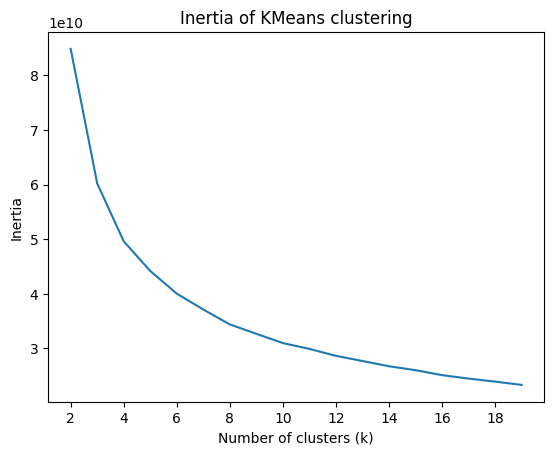

In [14]:
# clustering to explore if games fall into distinct groups
from sklearn.cluster import KMeans

# search for elbow point

inertia = []

# We want to analyze games only using features we would have available at the 10 minute mark
# Obviously we also want to drop our target variable
X = df.drop(columns=["blueWins"])

for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    print(f"{n_clusters} clusters: {kmeans.inertia_}")
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 20), inertia)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Inertia of KMeans clustering')
plt.xticks(np.arange(2, 20, 2.0))
plt.show()

It seems like the elbow occurs at $k=5$ clusters.

In [15]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
df["Cluster"] = kmeans.labels_

# check if clusters are balanced
df["Cluster"].value_counts()

Cluster
1    3078
2    2703
0    2219
3    1107
4     772
Name: count, dtype: int64

In [16]:
# see what features are most important for each cluster
cluster_means = df.groupby("Cluster").mean()
cluster_means

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,...,redAssists,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.785038,22.333484,3.043263,0.683641,7.894998,8.573682,0.464173,0.238846,0.063091,17552.935557,...,4.657503,0.290671,0.102298,0.006309,15419.175304,6.748806,17181.556557,209.525462,49.442992,20.952546
1,0.530214,22.701754,2.928200,0.517544,6.070500,6.588369,0.382716,0.203054,0.030864,16513.116634,...,6.146849,0.407083,0.144574,0.016569,16249.468161,6.916764,17906.251787,217.852177,51.214425,21.785218
2,0.270810,22.026637,2.654828,0.371069,4.648539,4.916759,0.276730,0.141324,0.010729,15578.884573,...,7.984462,0.500925,0.194229,0.046615,17213.141324,7.066371,18589.748798,224.760266,52.896781,22.476027
3,0.093948,21.315266,2.483288,0.237579,3.658537,3.846432,0.165312,0.068654,0.001807,14719.681120,...,10.849142,0.601626,0.297200,0.209575,18833.285456,7.266667,19444.200542,230.741644,54.465221,23.074164
4,0.932642,22.821244,2.870466,0.791451,10.715026,11.392487,0.566062,0.316062,0.313472,19243.378238,...,3.844560,0.211140,0.071244,0.002591,14622.615285,6.483420,16100.773316,192.680052,47.016839,19.268005


### Analysis of Clusters

Just looking at win rate, it seems that the clusters roughly describe:
* games where the blue team is favored, but there's still a 22% chance the red team wins
* games where both teams start out relatively close (but skews slightly blue)
* games where the red team is favored, but there's still a 27% chance the blue team wins
* games where the blue team gets a terrible start and has a >90% chance to lose
* games where the red team gets a terrible start and has a >93% chance to lose

Interestingly, the blue team won only 49.9% of their games across the entire data set, but seem to have a 53.0% chance to win in the "close" games 

In [17]:
# reindex by blueWins
cluster_means = cluster_means.reindex(cluster_means["blueWins"].sort_values().index)

# Label clusters
cluster_names = ["Blue Stomp", "Blue Favored", "Roughly Even", "Red Favored", "Red Stomp"]

# print statistics for each cluster
for i, cluster_name in enumerate(cluster_names):
    print(cluster_name)
    print(f"Number of games: {len(df[df['Cluster'] == i])}")
    print(f"Win rate: {len(df[(df['Cluster'] == i) & (df['blueWins'] == 1)])/len(df[df['Cluster'] == i])}")
    print(cluster_means.loc[i].sort_values(ascending=False))
    print()

Blue Stomp
Number of games: 2219
Win rate: 0.7850383055430374
blueTotalExperience             18778.871564
blueTotalGold                   17552.935557
redTotalExperience              17181.556557
redTotalGold                    15419.175304
blueGoldDiff                     2133.760252
blueExperienceDiff               1597.315007
blueTotalMinionsKilled            225.821992
redTotalMinionsKilled             209.525462
blueTotalJungleMinionsKilled       52.479495
redTotalJungleMinionsKilled        49.442992
blueCSPerMin                       22.582199
blueWardsPlaced                    22.333484
redWardsPlaced                     22.028391
redCSPerMin                        20.952546
blueAssists                         8.573682
blueKills                           7.894998
blueAvgLevel                        7.107706
redAvgLevel                         6.748806
redAssists                          4.657503
redKills                            4.392519
blueWardsDestroyed                  3.

In [18]:
# correlation between each feature and cluster
cluster_means.reset_index().corr().sort_values("Cluster", ascending=False)["Cluster"].drop("Cluster")

blueTowersDestroyed             0.571846
redTowersDestroyed              0.335741
blueKills                       0.182314
redAssists                      0.173346
redKills                        0.167197
redHeralds                      0.161475
blueAssists                     0.152184
blueTotalGold                   0.142515
redTotalGold                    0.095761
redDragons                      0.035752
blueHeralds                     0.033631
blueGoldDiff                    0.028055
blueExperienceDiff              0.021963
blueDragons                    -0.013760
blueTotalExperience            -0.033649
blueAvgLevel                   -0.043917
blueFirstBlood                 -0.045227
blueWins                       -0.064104
redTotalExperience             -0.076772
redTotalJungleMinionsKilled    -0.086929
redAvgLevel                    -0.095494
blueWardsPlaced                -0.107538
blueTotalMinionsKilled         -0.147815
blueCSPerMin                   -0.147815
blueTotalJungleM

Interestingly, the most correlated features indicate that how many towers each team destroyed were very highly correlated with which cluster each game was placed in, with a moderately weak correlation with kills. Experience and gold had a very small absolute correlation.

In [19]:
# try to determine most predictive features for each cluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

cluster_feature_importance = {}

for cluster in range(5):
    cluster_data = df[df["Cluster"] == cluster]

    y = cluster_data['blueWins']
    X = cluster_data.drop(columns=['blueWins', 'Cluster'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_scaler = preprocessing.StandardScaler().fit(X_train)

    X_train_scaled = X_train_scaler.transform(X_train)

    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    cluster_feature_importance[cluster] = feature_importance


# print out the most important features for each cluster
for i, cluster_name in enumerate(cluster_names):
    print(f"Cluster {i} ({cluster_name}):")

    for j, (feature, importance) in enumerate(cluster_feature_importance[i].items()):
        print(f"{j+1}. {feature}: {importance:.3f} (value: {cluster_means.loc[i, feature]:.3f})")
        if j == 4:
            print()
            break

Cluster 0 (Blue Stomp):
1. blueGoldDiff: 0.067 (value: 2133.760)
2. blueExperienceDiff: 0.060 (value: 1597.315)
3. redTotalGold: 0.060 (value: 15419.175)
4. blueTotalExperience: 0.057 (value: 18778.872)
5. blueTotalGold: 0.056 (value: 17552.936)

Cluster 1 (Blue Favored):
1. blueGoldDiff: 0.070 (value: 263.648)
2. blueExperienceDiff: 0.060 (value: 147.315)
3. blueTotalExperience: 0.060 (value: 18053.567)
4. blueTotalGold: 0.058 (value: 16513.117)
5. redTotalGold: 0.057 (value: 16249.468)

Cluster 2 (Roughly Even):
1. blueGoldDiff: 0.072 (value: -1634.257)
2. blueExperienceDiff: 0.063 (value: -1283.883)
3. redTotalGold: 0.058 (value: 17213.141)
4. blueTotalGold: 0.058 (value: 15578.885)
5. redTotalExperience: 0.057 (value: 18589.749)

Cluster 3 (Red Favored):
1. blueGoldDiff: 0.070 (value: -4113.604)
2. blueTotalExperience: 0.064 (value: 16273.240)
3. blueTotalGold: 0.062 (value: 14719.681)
4. blueExperienceDiff: 0.058 (value: -3170.960)
5. redTotalExperience: 0.056 (value: 19444.201)



The random forest classifier indicates that every cluster was strongly predicted by the gold difference and experience difference, which is the opposite of what the cluster correlation indicated. This is explained by the cluster correlation being a proxy for winrate, so we would expect gold and experience to matter in every single game, hence have a low correlation. This indicates that the most predictive feature not of a win, but of a stomp, is how many towers the team destroyed.

In [20]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-02-05 00:06:16.346795 (duration: 0:00:08.968593)
